In [ ]:
import chemprop
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import time
import umap
import xyz2mol
from tqdm import tqdm as tq
#from tqdm.notebook import tqdm_notebook as tqnb
from rdkit import Chem, DataStructs
from rdkit.Chem import MolToSmiles, MolFromSmiles, MACCSkeys, AllChem, Descriptors, rdDistGeom, rdMolAlign
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.SaltRemover import SaltRemover
from sklearn import svm
from sklearn import tree,manifold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.utils.fixes import loguniform
from sklearn.utils import shuffle
from rdkit.ML.Cluster import Murtagh,Butina,ClusterUtils

from collections import OrderedDict


### Processing of CREST data

In [ ]:
df = pd.read_csv('smiles_part2.csv', low_memory=False, names= ["SMILES"])
for g in df.SMILES:
    try:
        m = MolFromSmiles(g)
        m2 = Chem.AddHs(m)
        cids = AllChem.EmbedMultipleConfs(m2, numConfs=4)
        rmslist = []
        AllChem.AlignMolConformers(m2, RMSlist=rmslist)
        print(g)
    except:
        None

In [ ]:
crest = 'path_to_file'
i = 0
c_sizes = []
filenames = []
for fn in os.listdir(crest):
    i += 1
    if fn[-6:-4] == "_0":
        c_sizes.append(min(100,i))
        i = 0
    if i>300: continue
    filenames.append(fn)
print(len(filenames), len(c_sizes))
plt.hist(c_sizes,bins=50,range=(0,100))

### Write to .sdf
extract unique conformers from clustering on conformer IDs (cids)

In [ ]:
with Chem.SDWriter('cr.sdf') as w:
    for z, m in enumerate(tq(da['SMILES'])):
        try:
            mh = Chem.AddHs(MolFromSmiles(m))
            ps = rdDistGeom.ETKDGv3()
            #ps.numThreads = 0
            cids = rdDistGeom.EmbedMultipleConfs(mh,50,ps)
            m3d = Chem.RemoveHs(mh)
            dists = []
            for i in range(len(cids)):
                for j in range(i):
                    dists.append(rdMolAlign.GetBestRMS(m3d,m3d,i,j))
            clusts = Butina.ClusterData(dists, len(cids), 0.5, isDistData=True, reordering=True)
            for mol in [x[0] for x in clusts]:
                # WRITING FUNCTION!!
                w.write(m3d,confId=mol)
        except:
            None

In [ ]:
with Chem.SDWriter('ccm.sdf') as w:
    for z, m in enumerate(tq(da['SMILES'])):
        try:
            cids = []
            mh = Chem.AddHs(MolFromSmiles(m))
            for i in range(50):
                AllChem.EmbedMolecule(mh)
                AllChem.MMFFOptimizeMolecule(mh)
                mol = Chem.RemoveHs(mh)
                cids.append(mol)
            dists = []
            timeout = time.time() + 20
            iq = len(cids)
            for i in range(len(cids)):
                if time.time() > timeout:
                    iq = i
                    print(len(cids),iq)
                    break
                for j in range(i):
                    dists.append(rdMolAlign.GetBestRMS(cids[i],cids[j]))#, numThreads=0))
            clusts = Butina.ClusterData(dists, iq, 0.5, isDistData=True, reordering=True)
            for mol in [cids[x[0]] for x in clusts]:
                # WRITING FUNCTION!!
                w.write(mol)
            cids = []
        except:
            None
                

In [ ]:

m_sizes = []
j = 1
k = 0
mols = []
cids = []

with Chem.SDWriter('cr.sdf') as w:
    for z, fn in enumerate(tq(filenames)):
        #if z<17545: continue
        if fn[-6:-4] == "_0":
            timeout = time.time() + 30
            dists = []
            iq = len(cids)
            for i in range(len(cids)):
                if time.time() > timeout:
                    iq = i
                    print(len(cids),iq)
                    break
                for j in range(i):
                    dists.append(rdMolAlign.GetBestRMS(cids[i],cids[j]))#, numThreads=0))
            clusts = Butina.ClusterData(dists, iq, 0.5, isDistData=True, reordering=True)
            for mol in [cids[x[0]] for x in clusts]:
                # WRITING FUNCTION!!
                w.write(mol)
            cids = []
        try:
            filename = os.path.join(crest, fn)#, "crest_conformers.xyz")
            atoms, charge, xyz_coordinates = xyz2mol.read_xyz_file(filename)
            cids.append(Chem.RemoveHs(xyz2mol.xyz2mol(atoms, xyz_coordinates, charge=charge)[0]))
        except:
            None
    # k+=1
    # if k>=min(50,c_sizes[j]):
    #     k = 0
    #     j += 1
    #     m_sizes.append(sum(atoms))
        #m_sizes.append(len([x for x in atoms if x != 1]))

In [ ]:
#reference code for current filter clustering
maxd = -100
for j in range(0,5):
    for i in range(j,len(cids)):
        d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[i],refCid=cids[j])
        d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[i],refId=cids[j])
        delt = d1-d2
        if delt<-1e-5:
            print(f', {i}, {delt}')
        if delt>maxd:
            maxd = delt
            maxi = i
            maxj = j
d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[maxi],refCid=cids[maxj])
d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[maxi],refId=cids[maxj])
print(maxi,maxd,d1,d2)


### *Par generation. Extract biodeg targets, PubChem, and RDKit methods.

In [2]:
# Degradation data (dr). For each scheme, also include other schemes as applicable.
da = pd.read_excel('biodeg_target.xls',sheet_name="Sheet1")
dr = pd.read_excel('degradation_data.xls')
substructs = pd.read_excel('parameters.xls')
#da = pd.concat([da,dp],axis=1)
#pc_data = da.values[:,3:13]

f = []#"HBondDonorCount", "RotatableBondCount", "HeavyAtomCount", \
       #"ZStericQuadrupole3D", "FeatureAnionCount3D", "FeatureCationCount3D", "FeatureRingCount3D"]

for j in da:
    # "MolecularWeight", "ExactMass", "MonoisotopicMass","Volume3D", "XStericQuadrupole3D", "YStericQuadrupole3D", "ZStericQuadrupole3D"
    if j in ["SMILES","Target_INT", "Target","Volume3D","MolecularWeight", "MonoisotopicMass", "UndefinedAtomStereoCount", "UndefinedBondStereoCount"]: continue
    f.append(j)
f=[]
Xd = []
MolMethods = ['BalabanJ',
 'BertzCT',
 #'Chi0',
 #'Chi0n',
 #'Chi0v',
 'Chi1',
 #'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 #'ChiNn_',
 #'ChiNv_',
 'HallKierAlpha',
 #'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3']
_3Descs = [
 'CalcAsphericity',
 #'CalcCoulombMat',
 #'CalcCrippenDescriptors',
 #'CalcEEMcharges',
 'CalcEccentricity',#
 'CalcExactMolWt',
 'CalcFractionCSP3',
 'CalcInertialShapeFactor',#
 'CalcLabuteASA',
 'CalcNPR1',
 'CalcNPR2',
 'CalcPBF',
 'CalcPMI1',
 'CalcPMI2',
 'CalcPMI3',
 'CalcPhi',
 'CalcRadiusOfGyration',
 'CalcSpherocityIndex',
 'CalcTPSA',
]
multi_3Descs=[#'CalcCoulombMat',
 #'CalcCrippenDescriptors',
 #'CalcEEMcharges',
 #'CalcGETAWAY',
 'CalcMORSE',
 'CalcRDF',
 'CalcWHIM',
]
GETAWAY_entries = ["ITH","ISH","HIC","HGM","H0u","H1u","H2u","H3u","H4u","H5u","H6u","H7u","H8u","HTu",
"HATS0u","HATS1u","HATS2u","HATS3u","HATS4u","HATS5u","HATS6u","HATS7u","HATS8u","HATSu","H0m","H1m","H2m","H3m","H4m","H5m",
"H6m","H7m","H8m","HTm","HATS0m","HATS1m","HATS2m","HATS3m","HATS4m","HATS5m","HATS6m","HATS7m","HATS8m","HATSm","H0v","H1v",
"H2v","H3v","H4v","H5v","H6v","H7v","H8v","HTv","HATS0v","HATS1v","HATS2v","HATS3v","HATS4v","HATS5v","HATS6v","HATS7v","HATS8v",
"HATSv","H0e","H1e","H2e","H3e","H4e","H5e","H6e","H7e","H8e","HTe","HATS0e","HATS1e","HATS2e","HATS3e","HATS4e","HATS5e","HATS6e",
"HATS7e","HATS8e","HATSe","H0p","H1p","H2p","H3p","H4p","H5p","H6p","H7p","H8p","HTp","HATS0p","HATS1p","HATS2p","HATS3p","HATS4p",
"HATS5p","HATS6p","HATS7p","HATS8p","HATSp","H0i","H1i","H2i","H3i","H4i","H5i","H6i","H7i","H8i","HTi","HATS0i","HATS1i","HATS2i",
"HATS3i","HATS4i","HATS5i","HATS6i","HATS7i","HATS8i","HATSi","H0s","H1s","H2s","H3s","H4s","H5s","H6s","H7s","H8s","HTs","HATS0s",
"HATS1s","HATS2s","HATS3s","HATS4s","HATS5s","HATS6s","HATS7s","HATS8s","HATSs","RCON","RARS","REIG","R1u","R2u","R3u","R4u","R5u",
"R6u","R7u","R8u","RTu","R1u+","R2u+","R3u+","R4u+","R5u+","R6u+","R7u+","R8u+","RTu+","R1m","R2m","R3m","R4m","R5m","R6m","R7m",
"R8m","RTm","R1m+","R2m+","R3m+","R4m+","R5m+","R6m+","R7m+","R8m+","RTm+","R1v","R2v","R3v","R4v","R5v","R6v","R7v","R8v","RTv",
"R1v+","R2v+","R3v+","R4v+","R5v+","R6v+","R7v+","R8v+","RTv+","R1e","R2e","R3e","R4e","R5e","R6e","R7e","R8e","RTe","R1e+","R2e+",
"R3e+","R4e+","R5e+","R6e+","R7e+","R8e+","RTe+","R1p","R2p","R3p","R4p","R5p","R6p","R7p","R8p","RTp","R1p+","R2p+","R3p+","R4p+",
"R5p+","R6p+","R7p+","R8p+","RTp+","R1i","R2i","R3i","R4i","R5i","R6i","R7i","R8i","RTi","R1i+","R2i+","R3i+","R4i+","R5i+","R6i+",
"R7i+","R8i+","RTi+","R1s","R2s","R3s","R4s","R5s","R6s","R7s","R8s","RTs","R1s+","R2s+","R3s+","R4s+","R5s+","R6s+","R7s+","R8s+","RTs+"]
#print(len(GETAWAY_entries))
prs=[]
morserdfsuffix = ['u', 'm', 'v', 'e', 'p', 'i', 's']
fnames = {"MolMethods": MolMethods, "_3Descs": _3Descs, 
"CalcGETAWAY": GETAWAY_entries,
"CalcMORSE": ["MORSE_%s" %(i%32) + morserdfsuffix[i//32] for i in range(224)],
"CalcRDF": ["RDF_%s" %(5*(2+i%30)) + morserdfsuffix[i//30] for i in range(210)],
"CalcWHIM": ["WHIM_%s" %i for i in range(114)],#provisional
"MACCS":
    ['0'] + [i[1][0]+'>'+str(i[1][1]) for i in Chem.MACCSkeys.smartsPatts.items()],
"GCT": substructs.Pa.tolist(),}
def fix_CCS(CCS):
    
    CCS = MolToSmiles(MolFromSmiles(CCS))
    #CCS = CCS.replace('{t}','')
    #CCS = CCS.replace('{c}','')
    CCS = CCS.replace('Na{+}','Na+')
    #CCS = CCS.replace('P{+}','[PH3+]')
    #CCS = CCS.replace('N{+}','[NH3+]')
    #CCS = CCS.replace('N{-}','[NH-]')        
    CCS = CCS.replace('Ca{2+}','Ca++')        
    CCS = CCS.replace('Cu{2+}','Cu++')
    CCS = CCS.replace('Zn{2+}','Zn++')
    CCS = CCS.replace('Ba{2+}','Ba++')
    CCS = CCS.replace('O{-}','[O-]')  
    CCS = CCS.replace('S{-}','[S-]')  
    CCS = CCS.replace('Cl{-}','[Cl-]')        
    CCS = CCS.replace('Br{-}','[Br-]')
    #CCS = CCS.replace('n{+}','[nH+]')
    CCS = CCS.replace('K','[K]')
    
    #CCS = CCS.replace('S{-}','[S-]')
    CCS = CCS.replace('_','')
    #CCS = CCS.replace('{','[')
    #CCS = CCS.replace('}',']')    
    return CCS
def getdeg(dur = '28Days', classMode = 60, dr=dr):

    ##Gets all molecules according to ClassMode. Doesn't classify yet, but includes other classModes that can be classified.

    deg = {}
    for i,row in dr[dr.Duration==dur].iterrows():
        try:
            CCS = fix_CCS(row.SMILES)
            deg[CCS] = float(row.Data.rstrip('%'))
        except:
            None
    if classMode:
        for i, row in dr[dr.Duration!=dur].iterrows():
            try:
                CCS = fix_CCS(row.SMILES)
                doyg = float(row.Data.rstrip('%'))
                if doyg >= classMode and dur=="28Days":
                    #print(row.Duration)
                    deg[CCS] = doyg
                elif doyg < classMode and dur=='14Days':
                    #print(row.Duration)
                    deg[CCS] = doyg
            except:
                None
    print(sum(np.array(list(deg.values()))<classMode), sum(np.array(list(deg.values()))>=classMode),len(deg))
    return deg
def CalcFromsdf(path):
    calc = {"SMILES":[], "MolMethods":[], "_3Descs": [], "CalcMORSE": [], "CalcRDF": [], "CalcWHIM": [], "MACCS": [], "GCT": []}
    f=[]
    #f = ['XLogP', 'ExactMass', 'RotatableBondCount','BondStereoCount', 'YStericQuadrupole3D', 'ZStericQuadrupole3D', "ConformerModelRMSD3D", 'EffectiveRotorCount3D', 'ConformerCount3D']
    #f = ["HBondDonorCount", "HeavyAtomCount", "FeatureDonorCount3D", "FeatureCationCount3D", 'XLogP', "FeatureRingCount3D","FeatureHydrophobeCount3D","ConformerModelRMSD3D",] #ExactMass", "TPSA", "YStericQuadrupole3D"]
    with Chem.SDMolSupplier(path) as wdd:
        for mol in tq(wdd):
            #if i>10: break
            try:
                #need a .values + concatenation of da and dp
                Q=[]
                CCS = MolToSmiles(mol)
                CCS = CCS.replace('/','')
                CCS = CCS.replace('\\','')
                CCS = CCS.replace('@','')
                if f:
                    a_list = da[da.SMILES==CCS]
                for j in f:
                    Q += [float(a_list[j])]
                '''dps = dp[dp.SMILES==CCS]
                    #Y.append(Descriptors.NumValenceElectrons(MolFromSmiles(CCS)))
                    for j in prs:
                        Q += [float(dps[j])]'''
                ad = Chem.FindMolChiralCenters(mol,force=True,includeUnassigned=True)
                #if ad:
                    #print(CCS, ad)
                calc["SMILES"] += [CCS]
                ph = []
                for k in MolMethods:
                    MolM = getattr(Chem.GraphDescriptors,k)
                    ph += [MolM(mol)]
                calc["MolMethods"] += [ph]
                ph = []
                for k in _3Descs:
                    MolM = getattr(Chem.rdMolDescriptors,k)
                    ph += [MolM(mol)]
                calc["_3Descs"] += [ph]
                for k in multi_3Descs:
                    pass
                    MolM = getattr(Chem.rdMolDescriptors,k)
                    #print(k,len(MolM(mol)))
                    calc[k] += [MolM(mol)]
                ph = [k for k in MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(CCS))]
                calc["MACCS"] += [ph]
                #par = Chem.RDKFingerprint(Chem.MolFromSmiles(CCS))
                #pairFps = Pairs.GetAtomPairFingerprint(Chem.MolFromSmiles(CCS))
                #print(pairFps.GetNonzeroElements())
                ph = []
                for k in fnames["GCT"]:
                    ph += [len(mol.GetSubstructMatches(Chem.MolFromSmarts(k)))]
                calc["GCT"] += [ph]
            except:
                None
    
    #all fingerprints to be SVD
    '''        
    svd = TruncatedSVD(n_components=40)
    svd.fit(Xd)
    Xd  = svd.transform(Xd)
    for i in range(len(X)):
        X[i] = list(Xd[i]) + X[i]
    '''
    for d in calc:
        print(d,len(calc[d]))
    return calc
def CalcFromDB(path):
    calc = {"SMILES":[], "MolMethods":[], "_3Descs": [], "CalcMORSE": [], "CalcRDF": [], "CalcWHIM": [], "MACCS": [], "GCT": []}
    from ast import literal_eval
    dcc = pd.read_excel(path, skiprows = 0)
    dcc = dcc.drop(columns=["Unnamed: 0"])
    calc['SMILES'] = dcc.SMILES.to_list()
    for p, r in dcc.iteritems():
        if p=='SMILES': continue
        if p=='MACCS': continue
        calc[p] = [literal_eval(q) for q in r]
        print(p,len(calc[p]))
    #for p in dcc:
        #print(pd.eval(p))
    #calc = dcc.to_dict('records')
    #print(pd.eval(calc[0]["CalcMORSE"]))
    print(calc["MolMethods"][1][9])
    #fnames["MolMethods"][9]
    #print(dcc.SMILES.to_list())
    return calc

### Write calc to .xlsx

In [ ]:
calc = CalcFromsdf(path="c7.sdf") #calc - oldconformers
zzmols = set(calc["SMILES"])
print(len(zzmols))
zzmolconfs = []
for u in zzmols:
    zzmolconfs.append(calc["SMILES"].count(u))
plt.hist(zzmolconfs,bins=50)
plt.xlabel('Conformers used')
plt.ylabel("No. of molecules")
calc['CalcWHIM']
dcc = pd.DataFrame(data=calc)
dcc.to_excel("c7.xlsx")

### SMILES reading, RDKit conformer generation (to .sdf)

In [ ]:
dx = pd.read_csv('Canonicalized_SMILES.csv')
deg_old = {}
for c in dx['SMILES']:
    c =  MolToSmiles(MolFromSmiles(c))
    deg_old[c]=0
_new = []
for i in deg_new:
    try:
        deg_old[i]
    except:
        _new.append(i)
deg_old,len(_new)

In [ ]:
# for k in dir(Chem.GraphDescriptors):
# ww.append(k)

with Chem.SDWriter('c9.sdf') as w:
    for m in tq(deg):
        try:
            for a in range(1):
                mol = Chem.MolFromSmiles(m)
                mol = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol)
                AllChem.MMFFOptimizeMolecule(mol)
                mol = Chem.RemoveHs(mol)
                # display(mol)
                w.write(mol)
                # previously our classes were 1:2, balance the former
                if (deg[m] > classMode):
                    mol = Chem.MolFromSmiles(m)
                    mol = Chem.AddHs(mol)
                    AllChem.EmbedMolecule(mol)
                    AllChem.MMFFOptimizeMolecule(mol)
                    mol = Chem.RemoveHs(mol)
                    # display(mol)
                    w.write(mol)
        except:
            None

In [ ]:
#test mols
with Chem.SDMolSupplier('c8.sdf') as w:
    k=0
    for a in w:
        print(Chem.MolToSmiles(a))
        try:
            print(deg[Chem.MolToSmiles(a)])
        except:
            None
        display(a)
        k=k+1
        if (k>20): break


### Clustering (OLD)

In [ ]:
fps={}
with Chem.SDMolSupplier('c8.sdf') as wdd:
    for mol in tq(wdd):
        try:
            CCS = MolToSmiles(mol)
            fps[CCS] = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
            #fps[CCS] = MACCSkeys.GenMACCSKeys(mol)
        except:
            None
    sim = [[1-DataStructs.FingerprintSimilarity(x, y) for y in list(fps.values())] for x in list(fps.values())]
dist_sim=[]
for i in range(len(sim)):
    dist_sim += sim[i][0:i]
print(len(fps),len(sim))
dist_sim

In [ ]:
clust = Butina.ClusterData(dist_sim,len(sim),0.6,1)
print([len(k) for k in clust])
for u in clust:
    for v in u:
        print(list(fps.keys())[v])
    print("\n")

In [ ]:
# sim = np.array(sim)
#plt.plot(sim[0:12].T)
from rdkit.ML import Cluster
clust = Murtagh.ClusterData(dist_sim,len(sim),Murtagh.WARDS,1)
for r in clust[0].GetChildren():
    print(r.Print())
ClusterUtils.GetNodesDownToCentroids(clust[0], above=1)
clusting=[]
for r in ClusterUtils.SplitIntoNClusters(clust[0],10):
    clusting.append([k.GetData() for k in r.GetPoints()])
for k in clusting:
    print(len(k))
for u in clusting:
    for v in u:
        print(list(fps.keys())[v])
    print("\n")

### *DATA LOADER - .xlsx to calc[]


In [ ]:
calc = CalcFromDB(path="calc7.xlsx") #calc - oldconformers


In [ ]:
zzmols = set(calc["SMILES"])
print(len(zzmols))
zzmolconfs = []
for u in zzmols:
    zzmolconfs.append(calc["SMILES"].count(u))
plt.hist(zzmolconfs,bins=50)
plt.xlabel('Conformers used')
plt.ylabel("No. of molecules")
calc['CalcWHIM']
plt.hist(zzmolconfs,bins=27)

In [ ]:
def check_dr(dr):
    deg_new={}
    for i,row in dr.iterrows():
        try:
            CCS = row.SMILES.replace('/','')
            CCS = CCS.replace('\\','')
            CCS = CCS.replace('@','')
            CCS = MolToSmiles(MolFromSmiles(CCS))
            deg_new[CCS] = float(row.Data.rstrip('%'))
        except:
            None
    return deg_new
def check_zzmols(zzmols):
    zzmol = {}
    for CC in zzmols:
        CCS = CC.replace('/','')
        CCS = CCS.replace('\\','')
        CCS = CCS.replace('@','')
        CCS = MolToSmiles(MolFromSmiles(CCS))
        try:
            print(CC,CCS,zzmol[CCS])
        except:
            zzmol[CCS]=0
    print(len(zzmol), len(zzmols))
    return zzmol
    k=0
def check_deg(deg,zzmol):
    for z,CC in enumerate(deg.keys()):
        CCS = CC.replace('/','')
        CCS = CCS.replace('\\','')
        CCS = CCS.replace('@','')
        CCS = MolToSmiles(MolFromSmiles(CCS))
        assert(CC==CCS)
        try:
            zzmol[CCS]
        except:
            print(CCS)
            k += 1
    return k

### Set up the x and y from calc[]
- Get the pre-filtered matrix (Mansouri 2013) ('fB') parameters
- fix CCS

In [ ]:
sp={'CalcWHIM': [False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'CalcRDF': [False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, True, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'CalcMORSE': [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, True, False, False, False, True, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False]}
getFeatureMask = {'CalcWHIM': [8, 9, 19, 28, 41, 42, 48, 66],
'CalcRDF': [2, 5, 31, 34, 35, 36, 38, 45, 62, 64, 65, 75, 87, 92, 94, 121, 123, 124, 155, 156, 158, 182, 183, 188],
'CalcMORSE': [2, 32, 39, 40, 44, 48, 62, 64, 66, 67, 71, 75, 77, 108, 109, 112, 116, 126, 128, 162, 163, 192, 200, 203, 222]
}
for k in getFeatureMask:
    #gamma = [x for x,i in enumerate(sp[k]) if i]
    #print(k,gamma,len(fnames[k]))
    sp[k] = [True if i in getFeatureMask[k] else False for i in range(len(fnames[k]))]
deg_new={}
rej=[]
for i,row in dr.iterrows():
        try:
            CCS = fix_CCS(row.SMILES)
            CCS = MolToSmiles(MolFromSmiles(CCS))
            deg_new[CCS] = float(row.Data.rstrip('%'))
        except:
            rej.append([CCS,row.SMILES])
len(deg_new),len(rej)

In [ ]:
classMode = 60

deg = getdeg('28Days', classMode, dr)
X = []
Y = []
g = []
SMILEScount = 1
samecount = 1
last_CCS = 0
rej_CCS = set()

elimratio=sum(np.array(list(deg.values()))>classMode)/sum(np.array(list(deg.values()))<classMode)
for i, CCS in enumerate(tq(calc["SMILES"])):
    CCS = CCS.replace('/','')
    CCS = CCS.replace('\\','')
    CCS = CCS.replace('@','')
    #m1 = MolFromSmiles(CCS)
    #m1 = SaltRemover().StripMol(m1)
    fA = ["GCT","MolMethods","_3Descs"] #GETAWAY_entries
    fB = ["CalcMORSE", "CalcRDF", "CalcWHIM"]
    CCS = MolToSmiles(MolFromSmiles(CCS))
    try:
        Q=[]
        #Y.append(calc["MolMethods"][i][1])#float(da.XLogP[i]))#YStericQuadrupole3D
        #untagged CCS do not run below     
        if 1:
            if last_CCS==CCS:
                samecount += 1 #Q = X[-1]
            else:
                samecount = 1
                SMILEScount += 1
            if samecount > 5:
                #continue
                samecount = 1
        last_CCS = CCS
        if deg[CCS]<classMode and np.random.rand()>0.67:#and samecount>1 :
            continue
            Y.append(deg[CCS])
            g.append(CCS)
            X.append(Q)
        for k in fA:
            Q += calc[k][i]
        for k in fB:
            Q += np.array(calc[k][i])[sp[k]].tolist()
        Y.append(deg[CCS])
        g.append(CCS)
        X.append(Q)
    except:
        rej_CCS.add(CCS)

g = [{v: k for k, v in enumerate(OrderedDict.fromkeys(g))} [n] for n in g]
f = []
for k in fA:
    print(k)
    f += fnames[k]

for k in fB:
    print(k)
    f += np.array(fnames[k])[sp[k]].tolist()

sr = VarianceThreshold(1e-2)
X = sr.fit_transform(X)
f = sr.get_feature_names_out(f)

plt.hist(Y,bins=60)#,range=(10,110))
plt.xticks(np.arange(0,max(Y),10))
plt.xlabel("Biochemical Oxygen Demand")
plt.ylabel("Number of compounds")
plt.show()
#archive
X,Y,f,g = np.array(X),np.array(Y),np.array(f),np.array(g)
arcX, arcY, arcf, arcg = X,Y,f,g

X.shape,Y.shape,Y.mean(),g[:100],sum(Y>classMode)/sum(Y<classMode),SMILEScount,len(set(g)),len(rej_CCS)
#pd.DataFrame(X,index=g,columns=f).head(15)

In [ ]:
def InitData(classMode, cors_th, nm_x=True):
    mask = None
    g = arcg
    if classMode:
        Y = np.array([min(1, int((a)/classMode)) for a in arcY])
    else:
        Y = arcY
    #correlation filter
    if cors_th:
        cors = abs(np.corrcoef(np.transpose(arcX)))
        to_rm = set()                                
        for a in cors:  # eliminate correlations
            if (a > cors_th).sum() > 1:
                for c in np.nonzero(a > cors_th):
                    for b in c:
                        if cors[b].sum() > a.sum():
                            to_rm.add(b)
        mask = [i not in to_rm for i in range(len(arcf))]
        X = arcX[:, mask]
        f = arcf[mask]
    else:
        X = arcX
        f = arcf
    if nm_x:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
    return X, Y, f, mask


X, Y, f, mask = InitData(60, cors_th=0.97)
X, Y, g = shuffle(X, Y, g)
# re-number g
#g = [{v: k for k, v in enumerate(OrderedDict.fromkeys(g))}[n] for n in tq(g)]
#g = np.array(g)
# X(f*g), Y(g)
X.shape, Y.shape, g.shape, X.mean(), Y.mean(), len(f), g[:100], #Y[0:100], X[101:102], f

### Chemprop
- ONLY .csv files from this point are produced by Chemprop!

In [ ]:
!pip install chemprop==1.6.1.dev0

In [ ]:
##only for generating the csv
classMode = 60
deg = getdeg('28Days', classMode, dr)
feas = []
for CCS in deg:
    
    #CCS = CCS.replace('/','')
    #CCS = CCS.replace('\\','')
    #CCS = CCS.replace('@','')
    CSSS = fix_CCS(CCS)
    #try:
    #v = calc[calc['SMILES'] == CCS]
    #print(v)
    if(deg[CCS]<60):
        deg[CCS] = 0
    else:
        deg[CCS] = 1
    # except:
    #     None
dcc = pd.DataFrame.from_dict(data=deg,orient="index")
dcc.to_csv("cr_r.csv")

In [ ]:
arguments = [
    '--data_path', 'cr1.csv',
    '--dataset_type', 'regression', #<----------------------------
    '--metric', 'r2',
    '--num_folds', '5',
    '--save_dir', 'cr_checkpoints'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:

arguments = [
    '--config_save_path', 'hp.json',
    '--data_path', 'cr1.csv',
    '--dataset_type', 'classification',
    '--metrics', 'f1'
]
args = chemprop.args.HyperoptArgs().parse_args(arguments)
chemprop.hyperparameter_optimization.hyperopt(args=args)

In [13]:
chemprop.features.features_generators.get_available_features_generators()

['morgan', 'morgan_count', 'rdkit_2d', 'rdkit_2d_normalized']

In [ ]:
#import chemprop
arguments = [
    '--config_path', 'hp.json',
    '--data_path', 'cr_r.csv',
    '--dataset_type', 'classification',
    '--features_generator', 'rdkit_2d_normalized',
    '--no_features_scaling',
    '--metric', 'accuracy',
    '--quiet',
    '--class_balance',
    '--num_folds', '5',
    '--save_dir', 'cu_checkpoints'
]
args = chemprop.args.TrainArgs().parse_args(arguments)
#args.features_generator = ['morgan_count', 'rdkit_2d_normalized']
args.extra_metrics = ['balanced_accuracy',  'recall', 'precision', 'f1','auc']
#print(args.extra_metrics)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
arguments = [
    '--test_path', 'cza.csv',
    '--preds_path', 'czp.csv',
    '--checkpoint_dir', 'cu_checkpoints'
]
args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

In [ ]:
arguments = [
    '--data_path', 'ca.csv',
    '--checkpoint_dir', 'cd_checkpoints'
]
args = chemprop.args.InterpretArgs().parse_args(arguments)
#interprets = chemprop.train.evaluate_predictions
chemprop.interpret()

## Training and Testing

In [12]:
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, StratifiedGroupKFold, GroupShuffleSplit #we don't need GroupStrat for now
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
#import seaborn as sns
def udr(embedding,Y):
    fig, axs = plt.subplots(1,embedding.shape[1]-1)
    for p in range(embedding.shape[1]-1):
        axs[p].scatter(embedding[:, 0],embedding[:, p+1],c=Y,marker=0)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()
    return #embedding
    #plt.title('UMAP projection of the Penguin dataset', fontsize=24)
def udr_old(X, Y=None, min_dist=0.1, n_neighbors=15, n_components=2):
    reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
         force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
         local_connectivity=1.0, low_memory=False, metric='euclidean',
         metric_kwds=None, min_dist=min_dist, n_components=n_components, n_epochs=None,
         n_neighbors=n_neighbors, negative_sample_rate=5, output_metric='euclidean',
         output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
         set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
         target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
         transform_queue_size=4.0, transform_seed=None, unique=False, verbose=False)
    Xw = StandardScaler().fit_transform(X)
    embedding = reducer.fit_transform(Xw,Y)
    embedding.shape
    plt.scatter(embedding[:, 0],embedding[:, 1],c=Y,marker=0)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()
    return embedding
    #plt.title('UMAP projection of the Penguin dataset', fontsize=24)
def tsn(X, min_dist=12, n_neighbors=30, n_components=2):
    reducer = manifold.TSNE(n_components=n_components, perplexity=n_neighbors, early_exaggeration=min_dist, learning_rate='warn',
                  n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
                  metric_params=None, init='warn', verbose=0, random_state=None, method='barnes_hut',
                  angle=0.5, n_jobs=None, square_distances='deprecated')
    Xw = StandardScaler().fit_transform(X)
    embedding = reducer.fit_transform(Xw,Y)
    #embedding.shape
    plt.scatter(embedding[:, 0],embedding[:, 1],c=Y,marker=0)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()
    return embedding
def tts(X,Y,g,test_size=0.25,random_state=0):
    train_indx, test_indx = next(GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state).split(X,Y,groups=g))
    #np.unique(g[train_indx]), np.unique(g[test_indx])
    #I continue to keep W for legacy purposes
    return X[train_indx], X[test_indx], Y[train_indx], Y[test_indx], g[train_indx], g[test_indx]
#udr_old(X,Y,0.1,15,4)
#tsn(X,12,30,2)
def confusion(X_test,X_train,Y_test,Y_train):
    Y1 = sklearn_model.predict(X_test)
    print(confusion_matrix(Y1,Y_test))
    print(classification_report(Y1,Y_test))
    print(balanced_accuracy_score(Y1,Y_test), sklearn_model.score(X_test,Y_test))

    Y1 = sklearn_model.predict(X_train)
    print(confusion_matrix(Y1,Y_train))
    print(classification_report(Y1,Y_train))
    print(balanced_accuracy_score(Y1,Y_train), sklearn_model.score(X_train,Y_train))
confusion(X_test,X_train,Y_test,Y_train)

#print(sklearn_model.best_estimator_)

In [ ]:
X,Y,f=InitData(classMode)

### Feature Reduction

In [ ]:
#dataset = dc.data.NumpyDataset(X, Y)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
sklearn_model = LogisticRegression(max_iter=500000,class_weight='balanced')
sklearn_model = svm.SVC(kernel='linear')#, class_weight='balanced')
#sklearn_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,max_features="sqrt",random_state=0)
rfecv = RFECV(
    estimator = sklearn_model,
    step = 2,
    cv = 5,
    scoring = "balanced_accuracy",
    #importance_getter = 'coef_',
    min_features_to_select = 1,
    n_jobs = -1,
    verbose = True
)
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("Random Forest")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, rfecv.step*len(rfecv.grid_scores_) + 1,rfecv.step),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
sklearn_model = LogisticRegression(max_iter=500000,class_weight='balanced')

#sklearn_model = RandomForestClassifier(n_estimators=20,n_jobs=-1,max_features="sqrt",random_state=0)
#selector = SelectFromModel(sklearn_model, max_features=50, threshold=-np.inf)# threshold = "0.5*mean")
selector = RFE(sklearn_model, n_features_to_select = 65)

selector = selector.fit(X, Y)
#for j in range(len(f)):
    #print(selector.ranking_[j])
X = selector.transform(X)
f = selector.get_feature_names_out(f)
print(f,len(f))

['[CH3,CH4]' '*-C(=O)-*' '*-[OR0]-*' '[O]=[C]-[O]-*' '[N]=*'
 '*-[CHR](-*)-*' '*-[CH2]-[OH]' 'n' '*-C(=[!O&!S])-*' '*-[CR](=O)-*'
 '[R][N](=O)O' '*-[S]-*' '[R0][C](=O)[OH]' '*-S=O' '*-[CH]-[OH]'
 '*-[CH0R](-*)(-*)-*' '[F][R0]' '[Br][R0]' '[Br][R]'
 '[CH2][CH2][C](=O)[OH]' '[NH2][CH]C=O' 'BalabanJ' 'BertzCT' 'Chi1'
 'Chi1v' 'Chi2v' 'Chi3n' 'Chi3v' 'Chi4n' 'HallKierAlpha' 'Kappa1' 'Kappa2'
 'CalcAsphericity' 'CalcFractionCSP3' 'CalcNPR2' 'CalcPBF' 'CalcPMI2'
 'CalcPhi' 'MORSE_2u' 'MORSE_0m' 'MORSE_7m' 'MORSE_12m' 'MORSE_30m'
 'MORSE_3v' 'MORSE_7v' 'MORSE_12e' 'MORSE_30e' 'MORSE_0p' 'MORSE_3i'
 'MORSE_0s' 'RDF_30m' 'RDF_40m' 'RDF_85m' 'RDF_20v' 'RDF_30v' 'RDF_145v'
 'RDF_15p' 'RDF_25p' 'RDF_30p' 'RDF_35i' 'RDF_40i' 'RDF_50i' 'RDF_20s'
 'RDF_50s' 'WHIM_66'] 65


In [ ]:
rfecv = RFE(sklearn_model, n_features_to_select = 64)
rfecv = rfecv.fit(X, Y)
print(f, rfecv.get_support())
sp1 = rfecv.get_support()
#mask using the original set,

print(mask)
ii = 0
for i, r in enumerate(mask):
    if(r==True):
        mask[i] = sp1[ii]
        ii+=1
#sp["CalcMORSE"] = mask
#print(mask)
sp

In [ ]:
for k in sp:
    print(k,np.count_nonzero(sp[k]),np.size(sp[k]))

CalcWHIM 8 114
CalcRDF 24 210
CalcMORSE 25 224


In [28]:
calca = np.array(calc["CalcMORSE"][1])
calca[sp["CalcMORSE"]]
ff1 = np.array(fnames["CalcMORSE"])
ff1[sp["CalcMORSE"]]

array(['MORSE_2u', 'MORSE_0m', 'MORSE_7m', 'MORSE_8m', 'MORSE_12m',
       'MORSE_16m', 'MORSE_30m', 'MORSE_0v', 'MORSE_2v', 'MORSE_3v',
       'MORSE_7v', 'MORSE_11v', 'MORSE_13v', 'MORSE_12e', 'MORSE_13e',
       'MORSE_16e', 'MORSE_20e', 'MORSE_30e', 'MORSE_0p', 'MORSE_2i',
       'MORSE_3i', 'MORSE_0s', 'MORSE_8s', 'MORSE_11s', 'MORSE_30s'],
      dtype='<U9')

In [ ]:
np.array(X).shape,np.array(Y).shape

((14110, 129), (14110,))

#### Logistic Reg


0.7864407354715832 [0.77405338 0.80136561 0.74736189 0.82929857 0.78012422]
0.7868289391041138 [0.77418432 0.80525078 0.74540259 0.82931994 0.77998707]
0.7864407354715832 [0.77405338 0.80136561 0.74736189 0.82929857 0.78012422]
0.7909222466771666 [0.77434383 0.82015922 0.74716516 0.82948938 0.78345365]
0.7858538795502281 [0.77410198 0.79946815 0.74698547 0.82927858 0.77943523]
0.7805370498405397 [0.76962025 0.78378378 0.72629455 0.83097726 0.7920094 ]


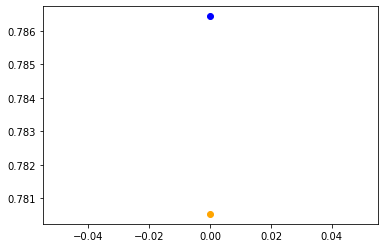

In [22]:
X_train , X_test , Y_train, Y_test, W_train, W_test = tts(X,Y,g,test_size=0.25,random_state=0)
sklearn_model = LogisticRegression(max_iter=500000, class_weight='balanced')#solver='saga')
sklearn_model = tree.DecisionTreeClassifier(max_depth=44, min_samples_leaf=2, random_state = 0)
sklearn_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,max_features="sqrt",random_state=0)
sklearn_model = svm.SVC(class_weight='balanced')#solver='saga')

n_comps = []
Qw=[]
Qx=[]
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5))
print(Q.mean(),Q)
plt.plot(0,Q.mean(),marker="o",color="blue")
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='balanced_accuracy')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='recall_weighted')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='precision_weighted')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='f1_weighted')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='f1')
print(Q.mean(),Q)
plt.plot(0,Q.mean(),marker="o",color="orange")

0.9597448618001417 [0.96172927 0.9588944  0.95747697 0.95712261 0.96350106]
0.9595610226533188 [0.96178522 0.95859807 0.95735907 0.95669654 0.96336622]
0.9597448618001417 [0.96172927 0.9588944  0.95747697 0.95712261 0.96350106]
0.960589886286859 [0.96246186 0.95994013 0.95824171 0.95800213 0.96430359]
0.959718539334682 [0.96171635 0.95885855 0.95745403 0.95708354 0.96348023]
0.9609066392925805 [0.96236934 0.96032832 0.95856354 0.9588015  0.96447051]


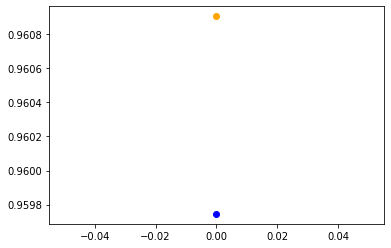

In [ ]:

X_train , X_test , Y_train, Y_test, W_train, W_test = tts(X,Y,g,test_size=0.25,random_state=0)
sklearn_model = LogisticRegression(max_iter=500000, class_weight='balanced')#solver='saga')
sklearn_model = tree.DecisionTreeClassifier(max_depth=44, min_samples_leaf=2, random_state = 0)
sklearn_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,max_features="sqrt",random_state=0)
sklearn_model = svm.SVC(class_weight='balanced')#solver='saga')

n_comps = []
Qw=[]
Qx=[]
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5))
print(Q.mean(),Q)
plt.plot(0,Q.mean(),marker="o",color="blue")
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='balanced_accuracy')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='recall_weighted')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='precision_weighted')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='f1_weighted')
print(Q.mean(),Q)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='f1')
print(Q.mean(),Q)
plt.plot(0,Q.mean(),marker="o",color="orange")

In [ ]:
X_train , X_test , Y_train, Y_test, W_train, W_test = tts(X,Y,g,test_size=0.05,random_state=5)
sklearn_model = LogisticRegression(max_iter=500000, class_weight='balanced')#solver='saga')
sklearn_model.fit(X_train,Y_train)
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5))# scoring='balanced_accuracy')
print(Q.mean(),Q,np.std(Q),sklearn_model.score(X_test,Y_test),sklearn_model.score(X_train,Y_train))
plt.plot(0,Q.mean(),marker="o",color="blue")
Q=cross_val_score(sklearn_model, X,Y, groups = g, cv = GroupKFold(5), scoring='f1')
print(Q.mean(),Q,np.std(Q),sklearn_model.score(X_test,Y_test),sklearn_model.score(X_train,Y_train))
plt.plot(0,Q.mean(),marker="o",color="orange")

#### Feature visualization

In [ ]:

coefs = []
ba = []
for i in tq(range(40)):
    X_train , X_test , Y_train, Y_test, W_train, W_test = tts(X,Y,g,test_size=0.05,random_state=i)
    sklearn_model = LogisticRegression(max_iter=500000, class_weight='balanced')#solver='saga')
    cross_val_score(sklearn_model, X_train,Y_train, groups = g, cv = GroupKFold(5))
    coefs.append(sklearn_model.coef_[0])
    ba.append([sklearn_model.score(X_test,Y_test),sklearn_model.score(X_train,Y_train)])

#print(pd.DataFrame(coefs,columns=f).T.to_string())
coefsa = np.array(coefs)
plt.figure(figsize=(5,30))
plt.grid()
print(pd.DataFrame([np.mean(coefsa,0),np.std(coefsa,0)],columns=f).T.to_string())
plt.barh(y=np.flip(f),width=np.mean(np.flip(coefsa),0),xerr=np.std(np.flip(coefsa),0))

#coefsa = np.flip(coefsa)
#print(pd.DataFrame([np.mean(coefsa,0),np.std(coefsa,0)],columns=f).T.to_string())

## Post-Processing

In [ ]:
coefs = []
ba = []
for i in tq(range(40)):
    X_train , X_test , Y_train, Y_test, g_train, g_test = tts(X,Y,g,test_size=0.2,random_state=i)
    sklearn_model = LogisticRegression(max_iter=500000, class_weight='balanced')#solver='saga')
    sklearn_model.fit(X_train,Y_train)#, groups = g_train, cv = GroupKFold(5))
    #coefs.append(sklearn_model.coef_[0])
    ba.append([sklearn_model.score(X_test,Y_test),sklearn_model.score(X_train,Y_train)])

plt.figure(figsize=(10,5))
plt.grid()
from matplotlib import pyplot as plt
from itertools import cycle
import numpy as np
colors = cycle(['#368195', '#4198AF', '#91C3D5', '#BBD7E3'])
bars=plt.bar(x=[i for i in range(len(ba[0]))],height=np.mean(ba,0),yerr=np.std(ba,0),color=[next(colors) for _ in range(len(ba[0]))])
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('accuracy')
plt.legend(handles=bars, labels=['test CREST', 'train CREST', 'test MMFF', 'train MMFF'],loc = 'center right',bbox_to_anchor=(1.2, 0.5))
plt.show()

In [ ]:
coefs = []
ba = []
for i in tq(range(40)):
    X_train , X_test , Y_train, Y_test, W_train, W_test = tts(X,Y,g,test_size=0.05,random_state=i)
    sklearn_model = LogisticRegression(max_iter=500000, class_weight='balanced')#solver='saga')
    cross_val_score(sklearn_model, X_train,Y_train, groups = g, cv = GroupKFold(5))
    coefs.append(sklearn_model.coef_[0])
    ba.append([sklearn_model.score(X_test,Y_test),sklearn_model.score(X_train,Y_train)])

plt.figure(figsize=(10,5))
plt.grid()

colors = cycle(['#368195', '#4198AF', '#91C3D5', '#BBD7E3'])
bars=plt.bar(x=[i for i in range(len(ba[0]))],height=np.mean(ba,0),yerr=np.std(ba,0),color=[next(colors) for _ in range(len(ba[0]))])
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('accuracy')
plt.legend(handles=bars, labels=['test CREST', 'train CREST', 'test MMFF', 'train MMFF'],loc = 'center right',bbox_to_anchor=(1.2, 0.5))
plt.show()